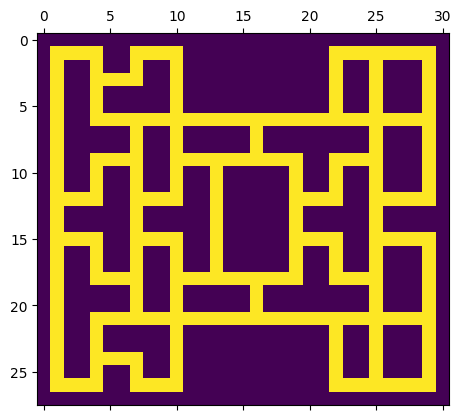

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.facecolor'] = 'white'
import math
import itertools
from pathlib import Path
import json

from collections import deque

from mdrc_pacbot_rl.pacman.grid import grid
from mdrc_pacbot_rl.pacman.variables import o, O, e
grid = np.array(grid)

COMPUTED_DATA_DIR = Path('computed_data')
COMPUTED_DATA_DIR.mkdir(exist_ok=True)

# do a flood fill to find the walkable grid cells
walkable_grid = np.zeros(grid.shape, dtype=bool)
queue = deque([(1, 1)])
while queue:
    x, y = queue.pop()
    for x2, y2 in [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]:
        if not walkable_grid[x2, y2] and grid[x2, y2] in {o, O, e}:
            walkable_grid[x2, y2] = True
            queue.append((x2, y2))

plt.matshow(walkable_grid)
plt.show()

# Compute the adjacency matrix for the graph of walkable cells

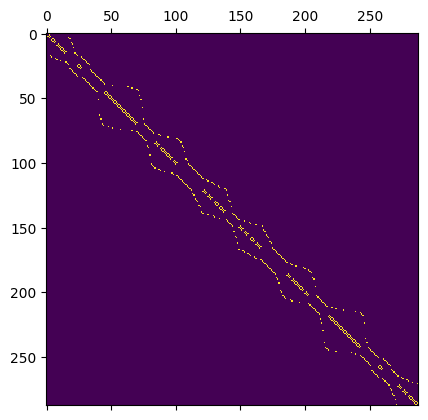

In [2]:
from scipy.sparse import csr_matrix

# create an array mapping graph node indices to grid coordinates
node_to_coords = list(zip(*walkable_grid.nonzero()))
coords_to_node = {coords: i for i, coords in enumerate(node_to_coords)}
num_nodes = len(node_to_coords)

with (COMPUTED_DATA_DIR / 'node_coords.json').open('w') as f:
    json.dump([(int(x), int(y)) for x, y in node_to_coords], f)

# build the adjacency matrix
edge_weights = []
mat_rows = []
mat_cols = []
def check_edge(i, coords2):
    if coords2 in coords_to_node:
        i2 = coords_to_node[coords2]
        edge_weights.append(1)
        mat_rows.append(i)
        mat_cols.append(i2)
        edge_weights.append(1)
        mat_rows.append(i2)
        mat_cols.append(i)
for i, (x, y) in enumerate(node_to_coords):
    check_edge(i, (x+1, y))
    check_edge(i, (x, y+1))

adj_matrix = csr_matrix((edge_weights, (mat_rows, mat_cols)))
plt.matshow(adj_matrix.toarray())
plt.show()

# Compute and visualize the eigenvectors of the graph laplacian

Note that the computation of the eigenvectors is not deterministic, so different runs may produce different (but equivalent, e.g. negated) eigenvectors.

In [3]:
import scipy.sparse.csgraph as csgraph
from scipy.sparse.linalg import eigsh

laplacian = csgraph.laplacian(adj_matrix).astype(float)

eigvals, eigvecs = eigsh(laplacian, k=num_nodes-1)
eigvecs = eigvecs.T

# *attempt* to reduce the non-determinism by making the sign of node 0's value consistently negative
# (doesn't work for eigenvectors where node 0 gets a value of about 0.0)
eigvecs[eigvecs[:, 0] > 0] *= -1

# since the eigenvector computation is not deterministic, try not to overwrite the saved eigvecs once computed so they stay consistent
eigvecs_file = COMPUTED_DATA_DIR / 'graph_lap_eigvecs.npy'
if not eigvecs_file.exists():
    np.save(eigvecs_file, eigvecs)
elif not np.allclose(eigvecs[:64], np.load(eigvecs_file)[:64]):
    print("WARNING: Some of the first 64 eigenvectors differ from those previously computed")

## Visualize the top eigenvectors

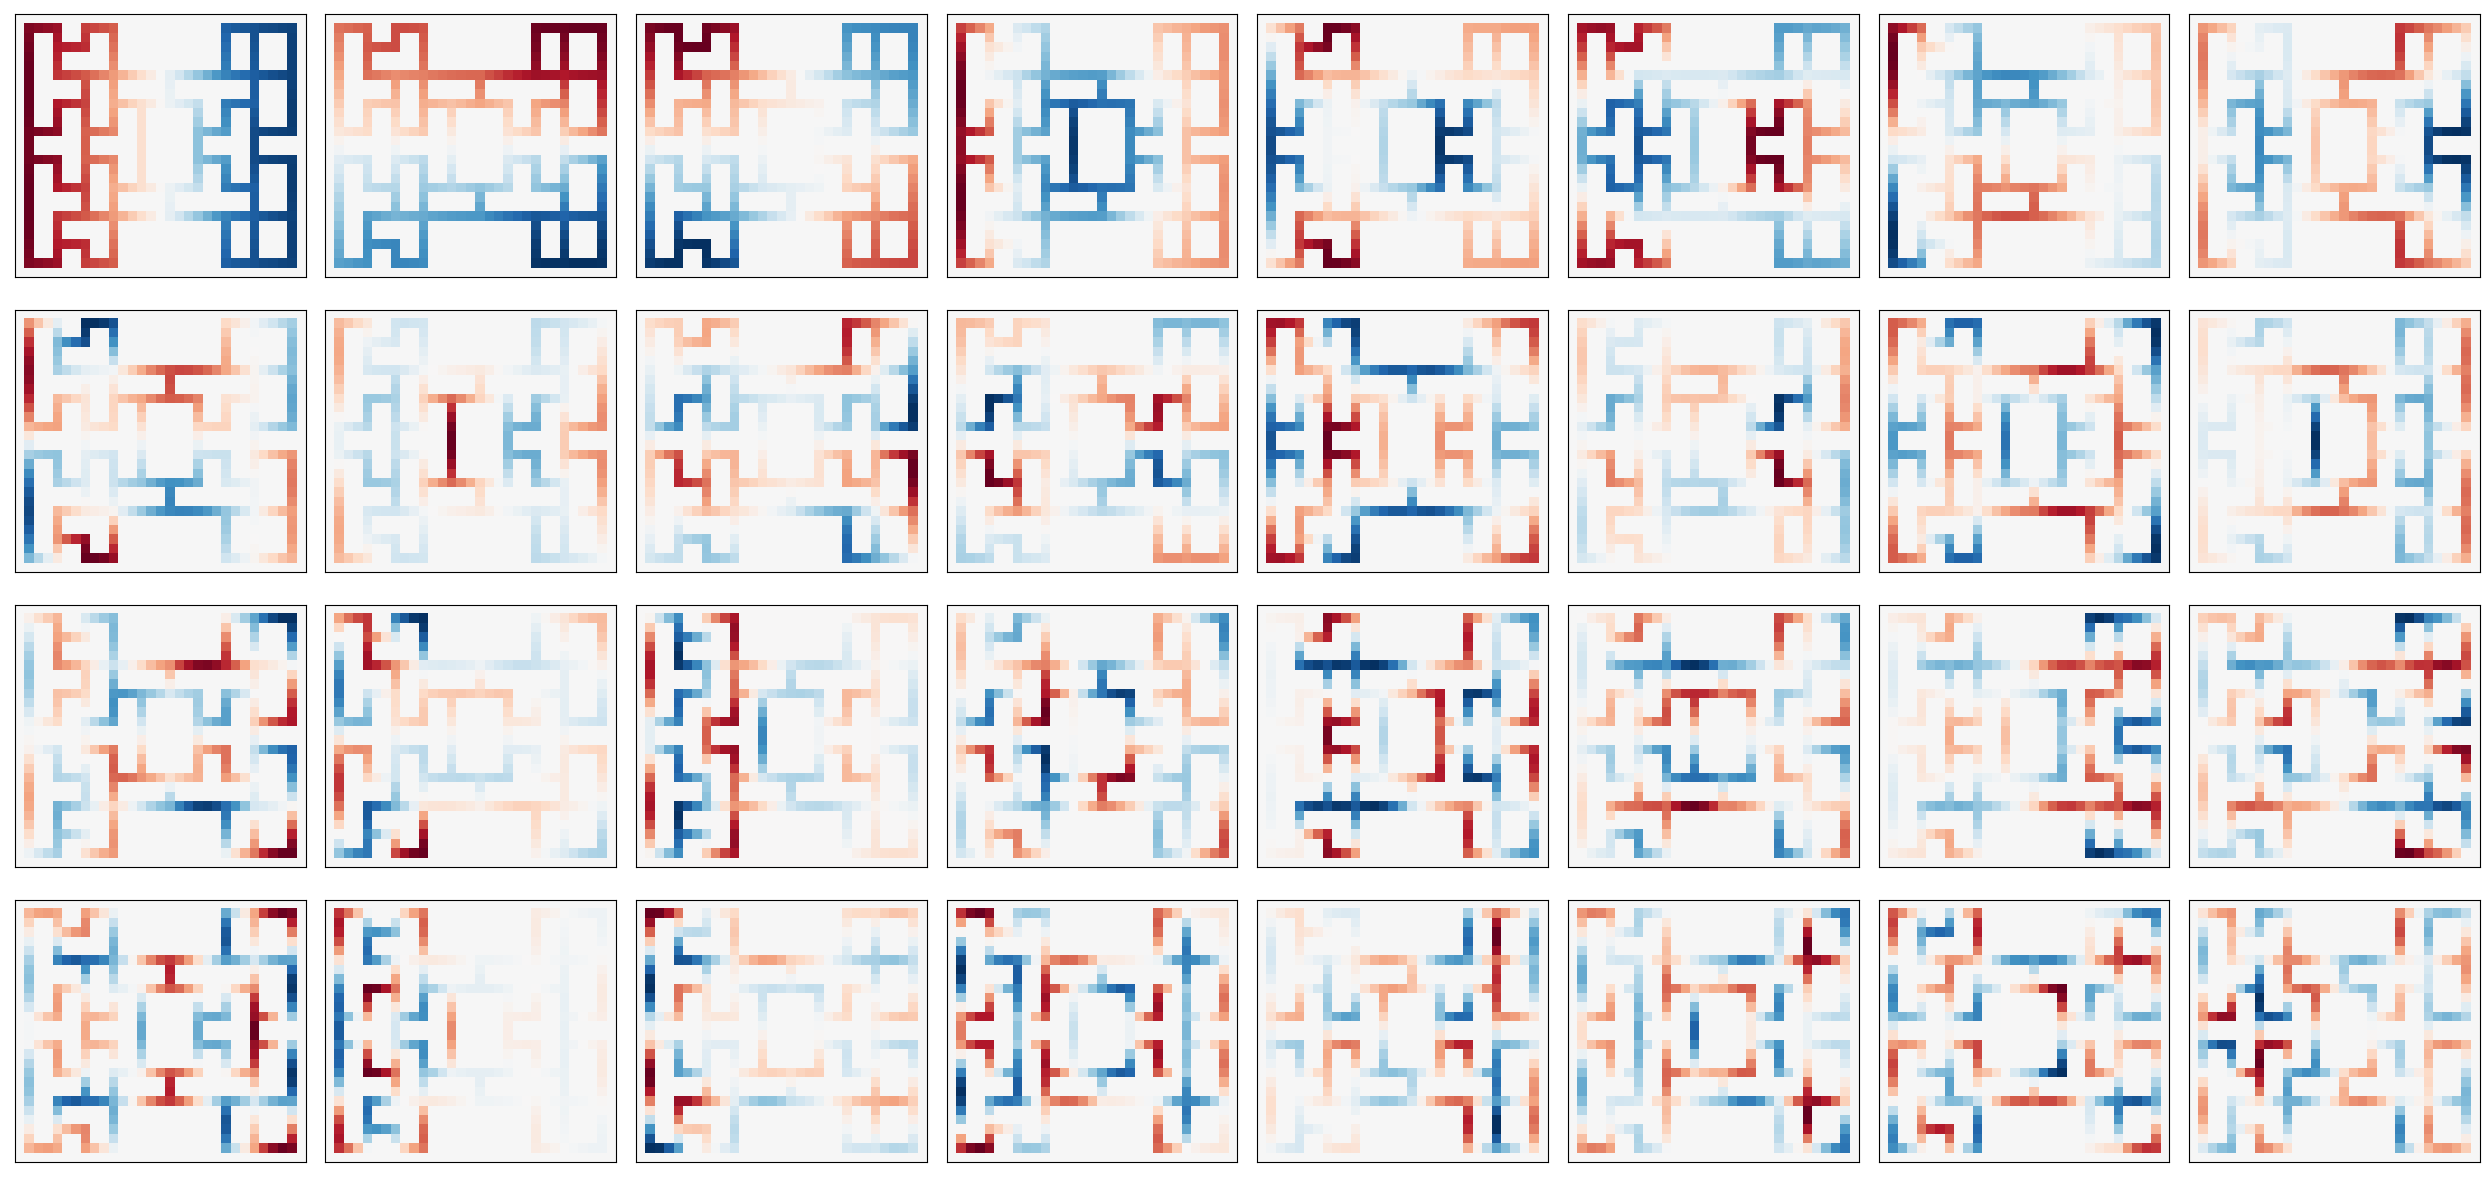

In [4]:
def node_values_to_grid(values, fill_value=0.0):
    """Converts an array of node values to a grid for visualization."""
    grid = np.full(walkable_grid.shape, fill_value)
    for i, (x, y) in enumerate(node_to_coords):
        grid[x, y] = values[i]
    return grid

def visualize_eigvecs(evecs):
    MAX_COLS = 8
    if len(evecs) <= MAX_COLS:
        ncols = len(evecs)
        nrows = 1
    else:
        ncols = MAX_COLS
        nrows = math.ceil(len(evecs) / MAX_COLS)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 3*nrows))
    for ax, evec in itertools.zip_longest(axes.flat, evecs):
        if evec is None:
            ax.axis('off')
        else:
            vis = node_values_to_grid(evec)
            vmax = np.abs(vis).max()
            ax.matshow(vis, vmin=-vmax, vmax=vmax, cmap='RdBu')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.tight_layout()
    plt.show()

visualize_eigvecs(eigvecs[:32])

## Show a different planar embedding of the graph, where the coordinates of each node are taken from the 1st and 2nd eigenvectors

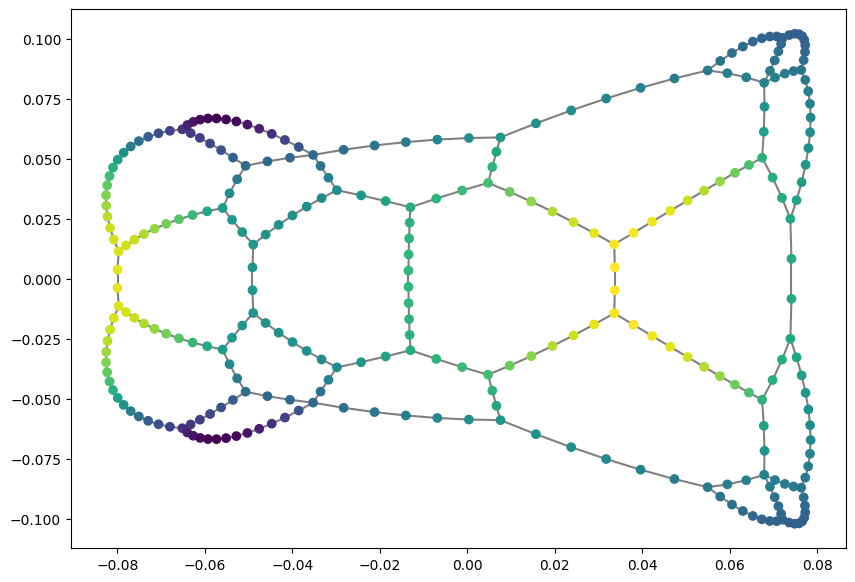

In [5]:
colors = eigvecs[2:2+3].T
colors = eigvecs[4]
colors -= colors.min()
colors /= colors.max()

positions = eigvecs[:2]

plt.figure(figsize=(10, 7))
plt.scatter(*positions, c=colors)
for i, j in zip(*adj_matrix.nonzero()):
    if i < j:
        x1, y1 = positions[:, i]
        x2, y2 = positions[:, j]
        plt.plot([x1, x2], [y1, y2], color='gray', zorder=-10)
plt.show()

# Explore cosine distances among graph-positional embedding vectors

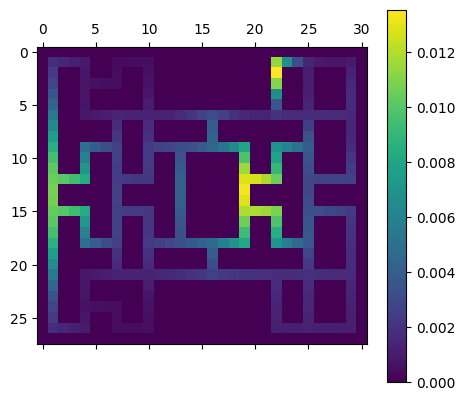

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

embed_dim = 64
node_embeddings = eigvecs[:embed_dim].T  # (num nodes) x (num positional embedding features)

query = np.random.randn(embed_dim)
# query = np.array([ 5.6208e-04,  4.1905e-04,  4.9270e-04,  1.6548e-04,  2.5457e-06,
#         -1.0912e-03, -2.8846e-04, -6.1325e-04])
query = node_embeddings[20]*10
# query[:] = 0
# query += node_embeddings[np.random.randint(num_nodes)]
# query += node_embeddings[100]
# query += node_embeddings[203]
# query = node_embeddings[::50].mean(axis=0) * 10
# query = node_embeddings[::50][5] * 10

similarities = cosine_similarity([query], node_embeddings).squeeze(axis=0)
vis = node_values_to_grid(similarities)
vis = node_values_to_grid(softmax(node_embeddings @ query * 1))
plt.matshow(vis)
plt.colorbar()
plt.show()

# Compute action distributions from target location distributions

Given the agent's current location and a distribution over target locations to move to, we want to determine a distribution over the possible actions to take next, out of the 5 possible actions:
 - `0`: Stay in place
 - `1`: Down (`y+1`)
 - `2`: Up (`y-1`)
 - `3`: Left (`x-1`)
 - `4`: Right (`x+1`)

The approach taken here is as follows. Given the current location, for each target location, the action distribution is uniform over the action(s) that will take shortest paths to that target. Then the total distribution is a sum of the action distributions for each possible target, weighted by the probability assigned to that target.

In [7]:
dist_matrix = csgraph.shortest_path(adj_matrix, directed=False, unweighted=True).astype(int)

# compute an action_distributions matrix that maps (current_node, target_node, action) to a probability/weight
action_distributions = np.zeros((num_nodes, num_nodes, 5), dtype=np.float32)
for i in range(num_nodes):
    x, y = node_to_coords[i]
    for j in range(num_nodes):
        if i == j:
            action_distributions[i, j, 0] = 1.0  # always pick action 0 (stay in place)
        else:
            dist = dist_matrix[i, j]
            def check_coords(action, coords):
                if coords in coords_to_node:
                    k = coords_to_node[coords]
                    if dist_matrix[k, j] == dist - 1:
                        action_distributions[i, j, action] = 1.0
            check_coords(1, (x, y+1))
            check_coords(2, (x, y-1))
            check_coords(3, (x-1, y))
            check_coords(4, (x+1, y))
            action_distributions[i, j] /= action_distributions[i, j].sum()

np.save(COMPUTED_DATA_DIR / 'action_distributions.npy', action_distributions)

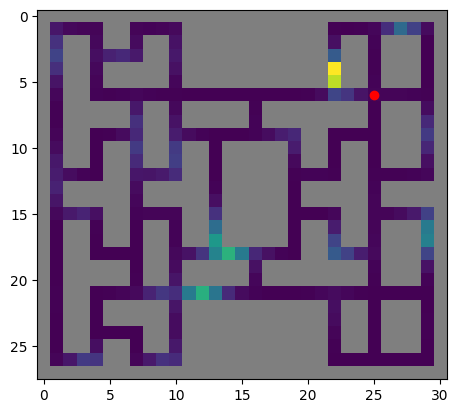

action_distr:  [0.00070116 0.03190011 0.51759006 0.04428122 0.40552744]


In [8]:
cur_loc = (6, 25)
query = np.random.randn(embed_dim) * 5
# query[:] = 0
# query += node_embeddings[np.random.randint(num_nodes)]
# query += node_embeddings[100]
# query += node_embeddings[203]
# query = node_embeddings[::50].mean(axis=0) * 10
# query = node_embeddings[::50][5] * 10

target_distr = softmax(node_embeddings @ query)
vis = node_values_to_grid(target_distr)
cmap = matplotlib.colormaps['viridis']
vis = cmap(vis / vis.max())
for (i, j), walkable in np.ndenumerate(walkable_grid):
    if not walkable:
        vis[i, j] = [0.5, 0.5, 0.5, 1]
plt.imshow(vis)
plt.scatter([cur_loc[1]], [cur_loc[0]], color='red')
# plt.colorbar()
plt.show()

action_distr = target_distr @ action_distributions[coords_to_node[cur_loc]]
with np.printoptions(suppress=True):
    print('action_distr: ', action_distr)

# Optimize/"learn" constant embeddings

Find embeddings (constrain to be unit-norm?) such that the square matrix of pairwise dot-products is as close as possible to the adjacency matrix?

In [9]:
import torch
from torch import nn
from torch.nn import functional as F

targets = torch.tensor(adj_matrix.toarray() + np.eye(num_nodes), dtype=float)
# plt.matshow(targets)
# plt.colorbar()
# plt.show()

embed_dim = 256
embeddings = torch.randn((num_nodes, embed_dim), requires_grad=True, dtype=float)
with torch.no_grad():
    embeddings /= torch.norm(embeddings, dim=1, keepdim=True)
    # embeddings[:] = embeddings[0]
    # torch.abs_(embeddings)
    # torch.sqrt_(embeddings)

opt = torch.optim.Adam([embeddings], lr=0.001)

In [10]:
adj_loss_weight = 10000.0

for _ in range(6000):
    opt.zero_grad()

    embeddings_unit = embeddings / torch.norm(embeddings, dim=1, keepdim=True)
    # embeddings_unit = torch.square(embeddings_unit)
    sims = embeddings_unit @ embeddings_unit.T
    loss = F.mse_loss(sims, targets, reduction='none')
    loss_weights = adj_loss_weight * targets / targets.sum(dim=0) + (1 - targets)
    loss = (loss_weights * loss).mean()
    # loss = (-(targets*2 - 1) * sims).mean()
    print(loss.numpy(force=True).item())
    loss.backward()

    opt.step()

23.880410401666126
23.06139261613321
22.257982928774528
21.471200597966078
20.70193171605557
19.95093178209732
19.21882963946948
18.50613515110935
17.813246157996122
17.140455097947665
16.48795709231014
15.85585847589972
15.244184502818461
14.652886024579065
14.081845615064156
13.530883467962207
12.999763190169045
12.488197613893941
11.995854560042849
11.522362355016837
11.067315079863043
10.63027759270459
10.21079028762412
9.808373566911797
9.422532055094972
9.052758533545154
8.69853754279033
8.359348657265807
8.034669449725246
7.723978147842383
7.426756003129071
7.1424893971915395
6.87067168720074
6.610804804561612
6.362400632190732
6.124982170021764
5.898084494249519
5.681255522983505
5.474056601124767
5.276062923323063
5.0868638216441155
4.906062937222788
4.733278292308423
4.568142279905612
4.4103015807931305
4.259417013557147
4.115163325233393
3.977228928381721
3.845315594579845
3.7191381182286825
3.5984239584817663
3.4829128641767473
3.372356487729646
3.2665179897445595
3.1651716

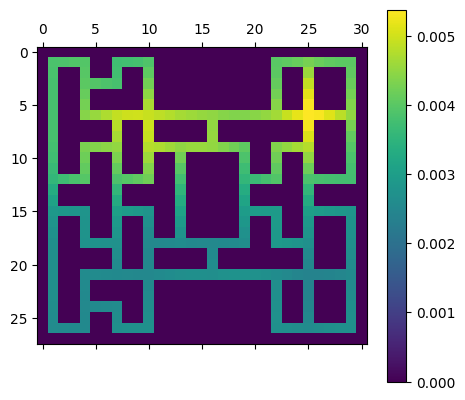

In [21]:
embeddings_np = embeddings.numpy(force=True).copy()

from sklearn.decomposition import PCA
pca = PCA(n_components=24)
pca.fit(embeddings_np)
embeddings_np = embeddings_np @ pca.components_.T

# print(np.linalg.norm(embeddings_np, axis=-1))
# embeddings_np = np.square(embeddings_np)
embeddings_np /= np.linalg.norm(embeddings_np, axis=-1, keepdims=True)

# np.save(COMPUTED_DATA_DIR / 'node_embeddings.npy', embeddings_np)

query = np.random.randn(embeddings_np.shape[1])
# query = np.array([ 5.6208e-04,  4.1905e-04,  4.9270e-04,  1.6548e-04,  2.5457e-06,
#         -1.0912e-03, -2.8846e-04, -6.1325e-04])
# query = embeddings_np[5] + embeddings_np[272]
# query = (embeddings_np[50+5] - embeddings_np[51+5])*2
# query = (embeddings_np[50+5] + embeddings_np[51+5])/2
# query = embeddings_np[239-12]
query = embeddings_np[:288//2].mean(axis=0)*4
# query[:] = 0
# query += node_embeddings[np.random.randint(num_nodes)]
# query += node_embeddings[100]
# query += node_embeddings[203]
# query = node_embeddings[::50].mean(axis=0) * 10
# query = node_embeddings[::50][5] * 10

plt.matshow(node_values_to_grid(softmax(embeddings_np @ query)))
plt.colorbar()
plt.show()

(24, 24)


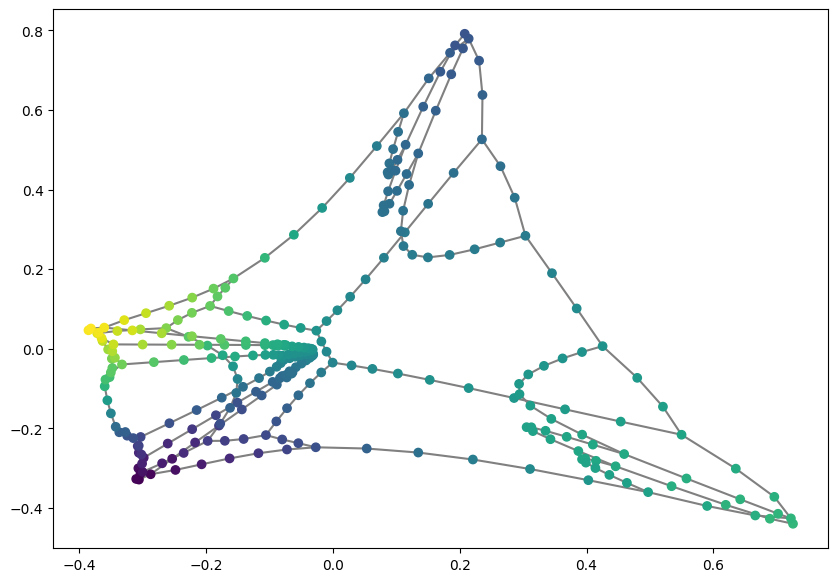

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(embeddings_np)
print(pca.components_.shape)
eigvecs = PCA().fit_transform(embeddings_np).T

# from scipy.stats import ortho_group
# eigvecs = (embeddings_np @ ortho_group.rvs(dim=embed_dim)).T
eigvecs = (embeddings_np @ pca.components_.T).T
# print(eigvecs.shape)
# print(np.linalg.norm(eigvecs, axis=0))

colors = eigvecs[2:2+3].T
colors = eigvecs[2]
# colors -= colors.min()
# colors /= colors.max()

positions = eigvecs[:2]

plt.figure(figsize=(10, 7))
plt.scatter(*positions, c=colors)
for i, j in zip(*adj_matrix.nonzero()):
    if i < j:
        x1, y1 = positions[:, i]
        x2, y2 = positions[:, j]
        plt.plot([x1, x2], [y1, y2], color='gray', zorder=-10)
plt.show()

In [13]:
minv = (embeddings_np @ embeddings_np.T).min()
((embeddings_np @ embeddings_np.T) == minv).nonzero()

(array([  8, 120]), array([120,   8]))

In [14]:
order = np.argsort(embeddings_np[0, :])[::-1]
# plt.matshow(node_values_to_grid(embeddings_np[:, order[4]]))
plt.matshow(node_values_to_grid(eigvecs[0]))
plt.colorbar()
plt.show()

IndexError: index 32 is out of bounds for axis 0 with size 24